# Interactive tutorial: extracellular electrical stimulation

## Objectives:
- Understand the concept of ***activating function*** as a predictor of neural excitability
- Understand the impact of various features on neural excitability, namely: 
    - **current polarity and intensity**
    - **electrode-fiber relative positioning**
    - **fiber morphology**
    - **medium properties**
- Understand the *interactions* between artificial electrical stimulation and physiological activity

To better understand these concepts, we will again turn to computational modeling, which consitutes an optimal tool to dissect biophysical interactions. 

## Imports

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [8]:
%matplotlib widget
from fibermodel import MyelinatedFiber
from medium import VolumeConductor
from stimulus import ExtracellularCurrentPulseTrain
from neuronsims import Simulation, interactive_sim
from logger import logger

## Basic model components

We will start by modeling the 3 components interacting in our system of interest, namely:
- **a spatially extended neuron model**
- **an electrically conducting extracellular medium**
- **an stimulation electrode** 

As you have seen during the course, the electrical excitability of neural structures depends on multiple factors such as neuronal morphology and the spatial distribution of the induced extracellular potential.

These interactions can be difficult to interpret if we consider the complex 3D $(x, y, z)$ morphology of brain neurons. Therefore, we will leverage here a simplified system, made of a **peripheral axon segment running on a straight line in a nerve**. The morphological and geometrical simplicity of this system allows us better understand stimulus-neuron interactions on a projected $(xz)$ plane, where $x$ is the direction of the fiber and $z$ is the perpendicular direction.

### Axon model

We are going to use a double-cable, multi-compartment model of a myelinated axon as defined in [McIntyre et al. 2002](https://doi.org/10.1152/jn.00353.2001). Because it incorporates a highly realistic morphology of the spatially distributed neural membrane, this so-called *MRG model* is a consolidated biophysical model used to study the excitability of myelinated axons by electrical fields.

Note that this model is parameterized as a function of axon diameter and number of nodes or Ranvier, such that it can be used to model myelinated axons or arbitrary diameters and lengths.

We will start by defining a "typical" axon of 10 μm diameter and comprising 101 nodes. This  corresponds to a axon length of about 11.5 centimeters, which is more than enough to study local interactions around the axon's mid-point with little to no "edge" effects.

In [9]:
diam = 20. # um
nnodes = 101 
fiber = MyelinatedFiber(diam, nnodes=nnodes)
logger.info(f'fiber is {fiber.length / 1e4:.2f} cm long')
fiber.get_details()

 18/02/2022 17:27:19: initializting model parameters...
 18/02/2022 17:27:19: creating model sections...
 18/02/2022 17:27:19: connecting model sections...
 18/02/2022 17:27:19: defining sections biophysics...
 18/02/2022 17:27:19: created MyelinatedFiber(20.0um, 101 nodes) model
 18/02/2022 17:27:19: fiber is 17.00 cm long


,nsec,nseg,diam (um),L (um),cm (uF/cm2),Ra (Ohm.cm),xr (MOhm/cm),xg (S/cm2),xc (uF/cm2)
node,101,1,7.5,1.0,2.0,70.0,148505.012216,1.000000e+10,0.000000
MYSA,200,1,7.5,3.0,2.0,70.0,148505.012216,2.941176e-06,0.000294
FLUT,200,1,17.5,68.0,2.0,70.0,31823.714626,2.941176e-06,0.000294
STIN,600,1,17.5,259.5,2.0,70.0,31823.714626,2.941176e-06,0.000294


### Extracellular medium

To start with, we will model the extracellular medium as an isotropic volume conductor model with a conducivity mimicking that of grey matter (σ=2 S/m).

In [10]:
medium = VolumeConductor(sigma=2.)

### Stimulus

We will consider the simple case of a point source electrode located 100 μm above the axon central node, injecting brief 100 μs pulses of cathodic current (-1 μA) in the extracellular medium.


In [23]:
stim = ExtracellularCurrentPulseTrain(
    pos=(0., 0., 100.),  # um
    I=-10.,  # uA
    tpulse=.1,  # ms
    npulses = 2,
    PRF = 0.2,  # kHz
    tstart=2. # ms
)
stim

ExtracellularCurrentPulseTrain(I=-10.00uA, tpulse=0.1ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)

Finally, we assemble all our model components into a simulation object:

In [27]:
sim = Simulation(fiber, medium, stim)

## Activating function

We will first look at the concept of activating function...

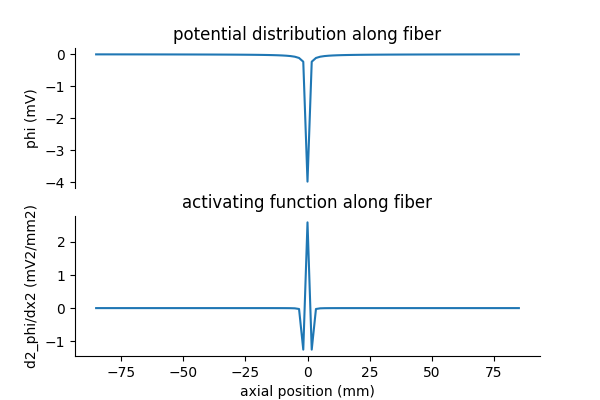

In [34]:
fig = sim.plot_profiles()

### Questions:

- *What is the nature of the extracellular potential profile along the axon?*
- *What is the nature of the activating function profile along the axon?*
- *How are those profiles affected by the current density? And by the electrode-axon distance?* 
- *Based on the profiles of the activating function, where do you expected the axon to be excited for cathodic stimuation ($I < 0$)? And for anodic stimulation ($I> 0$)?*
- *Based on these results, what type of stimulation (cathodic or anodic) will be more efficient?*

## Simulations

Let's verify the predictions formulated above by performing full-fledged simulations our our system.

### Impact of stimulation polarity (cathodic vs anodic)

 18/02/2022 17:51:15: simulating MyelinatedFiber(20.0um, 101 nodes) stimulation by ExtracellularCurrentPulseTrain(I=-10.00uA, tpulse=0.1ms, npulses=2, PRF=0.20kHz, tstart=2.0ms)...


Output()

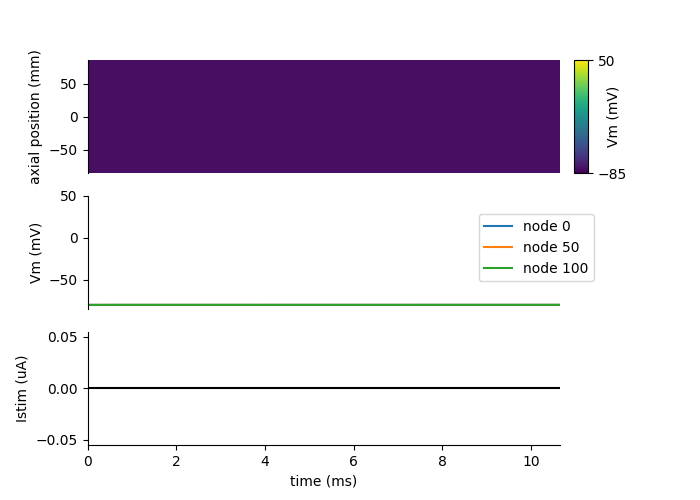

In [35]:
sim = Simulation(fiber, medium, stim)
interactive_sim(sim);

### Impact of pulse width (strength-duration curves)

### Impact of electrode-axon distance

### Impact of morphology

### Impact of medium properties

### Interaction between stimulation and physiological activity

## Conclusions